# Document Clustering and Topic Modeling

## Contents

* [Part 1: Load Data](#Part-1-Load-Data)
* [Part 2: Tokenizing and Stemming](#Part-2-Tokenizing-and-Stemming)
* [Part 3: TF-IDF](#Part-3-TF-IDF)
* [Part 4: K-means clustering](#Part-4-K-means-clustering)
* [Part 5: Topic Modeling - Latent Dirichlet Allocat](#Part-5-Topic-Modeling-Latent-Dirichlet-Allocat)


# Part 0: Setup Google Drive Environment

In [2]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [6]:
#https://drive.google.com/file/d/11hPPVXbw2bI85TvySgYi0bs9Oy-yeyTy/view?usp=drive_link
file = drive.CreateFile({'id':'11hPPVXbw2bI85TvySgYi0bs9Oy-yeyTy'}) # replace the id with id of file you want to access
file.GetContentFile('data.tsv')  # tab-separated

<a name='Part-1-Load-Data'></a>
# Part 1: Load Data

In [3]:
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

# import gensim

from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [7]:
# Load data into dataframe
df = pd.read_csv('data.tsv', sep='\t', on_bad_lines = 'skip')

In [8]:
df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,3653882,R3O9SGZBVQBV76,B00FALQ1ZC,937001370,"Invicta Women's 15150 ""Angel"" 18k Yellow Gold ...",Watches,5,0,0,N,Y,Five Stars,Absolutely love this watch! Get compliments al...,2015-08-31
1,US,14661224,RKH8BNC3L5DLF,B00D3RGO20,484010722,Kenneth Cole New York Women's KC4944 Automatic...,Watches,5,0,0,N,Y,I love thiswatch it keeps time wonderfully,I love this watch it keeps time wonderfully.,2015-08-31
2,US,27324930,R2HLE8WKZSU3NL,B00DKYC7TK,361166390,Ritche 22mm Black Stainless Steel Bracelet Wat...,Watches,2,1,1,N,Y,Two Stars,Scratches,2015-08-31
3,US,7211452,R31U3UH5AZ42LL,B000EQS1JW,958035625,Citizen Men's BM8180-03E Eco-Drive Stainless S...,Watches,5,0,0,N,Y,Five Stars,"It works well on me. However, I found cheaper ...",2015-08-31
4,US,12733322,R2SV659OUJ945Y,B00A6GFD7S,765328221,Orient ER27009B Men's Symphony Automatic Stain...,Watches,4,0,0,N,Y,"Beautiful face, but cheap sounding links",Beautiful watch face. The band looks nice all...,2015-08-31


In [9]:
# Remove missing value
df.dropna(subset=['review_body'],inplace=True)
df.reset_index(inplace=True, drop=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960045 entries, 0 to 960044
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   marketplace        960045 non-null  object
 1   customer_id        960045 non-null  int64 
 2   review_id          960045 non-null  object
 3   product_id         960045 non-null  object
 4   product_parent     960045 non-null  int64 
 5   product_title      960043 non-null  object
 6   product_category   960045 non-null  object
 7   star_rating        960045 non-null  int64 
 8   helpful_votes      960045 non-null  int64 
 9   total_votes        960045 non-null  int64 
 10  vine               960045 non-null  object
 11  verified_purchase  960045 non-null  object
 12  review_headline    960032 non-null  object
 13  review_body        960045 non-null  object
 14  review_date        960041 non-null  object
dtypes: int64(5), object(10)
memory usage: 109.9+ MB


In [11]:
df.nunique()

,0
marketplace,1
customer_id,719420
review_id,960045
product_id,149650
product_parent,141810
product_title,143429
product_category,1
star_rating,5
helpful_votes,284
total_votes,309


In [12]:
df.isnull().sum()

,0
marketplace,0
customer_id,0
review_id,0
product_id,0
product_parent,0
product_title,2
product_category,0
star_rating,0
helpful_votes,0
total_votes,0


In [ ]:
# use the first 1000 data as our training data
# data = df.loc[:999, 'review_body'].tolist()

In [13]:
# Randomly sample 10,000 rows from the DataFrame
df_sampled = df.sample(n=1000, random_state=42)
df_sampled.reset_index(drop=True, inplace=True)
# Access the 'review body' column from the sampled data
data = df_sampled['review_body']
data.reset_index(inplace=True,drop=True)


<a name='Part-2-Tokenizing-and-Stemming'></a>
# Part 2: Tokenizing and Stemming

Load stopwords and stemmer function from NLTK library.
Stop words are words like "a", "the", or "in" which don't convey significant meaning.
Stemming is the process of breaking a word down into its root.

In [14]:
# Use nltk's English stopwords.
stopwords = nltk.corpus.stopwords.words('english') #stopwords.append("n't")
stopwords.append("'s")
stopwords.append("'m")
stopwords.append("br") #html <br>
stopwords.append("watch")

print ("We use " + str(len(stopwords)) + " stop-words from nltk library.")
print (stopwords[:10])

We use 183 stop-words from nltk library.
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


Use our defined functions to analyze (i.e. tokenize, stem) our reviews.

In [15]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

def tokenization_and_stemming(text):
    tokens = []
    for word in nltk.word_tokenize(text):
        if word.lower() not in stopwords:
            tokens.append(word.lower())

    filtered_tokens = []

    for token in tokens:
        if token.isalpha():
            filtered_tokens.append(token)

    # stemming
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

In [16]:
from itertools import chain
data_processed=data.apply(tokenization_and_stemming)
all_tokens = list(chain.from_iterable(data_processed))

In [22]:
data_processed

,review_body
0,"[look, eleg, classi]"
1,"[face, rather, larg, delic, smaller, look, dre..."
2,"[purchas, wife, birthday, love, ship, time, we..."
3,"[review, base, initi, impress, today, feedback..."
4,"[year, old, timex, final, broke, band, local, ..."
...,...
995,"[husband, love, heavi, handsom, dont, like, ba..."
996,"[love, watch, like, give, gift, friend, one, b..."
997,"[sure, wrist, watch, dont, last, long, way, wo..."
998,"[money, paid, qualiti, item, box, surpris, ham..."


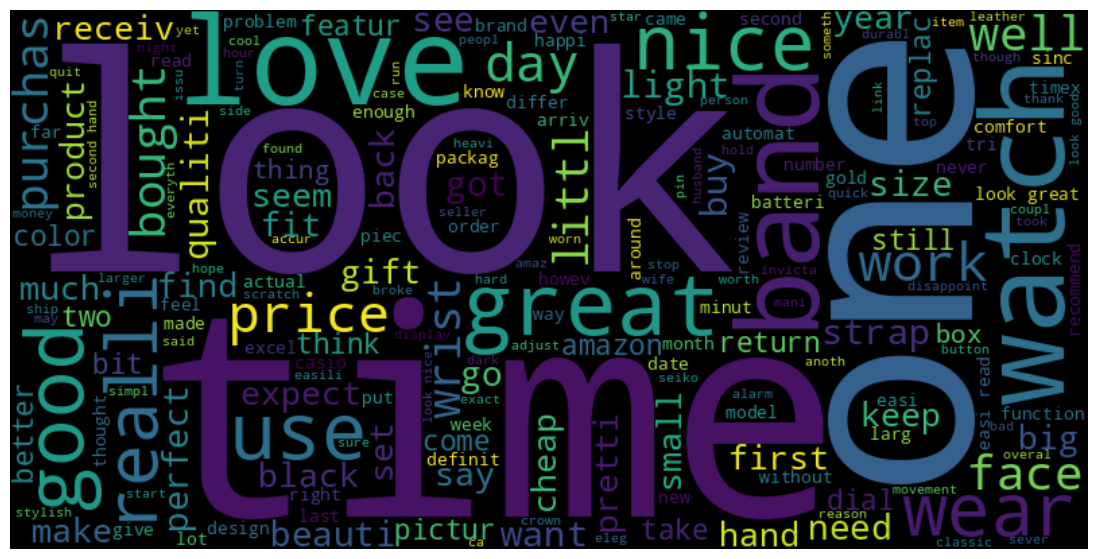

In [17]:
from wordcloud import WordCloud

# Generate a word cloud
text = ' '.join(all_tokens)
wordcloud = WordCloud(width=800, height=400).generate(text)

# Display the word cloud
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


The word cloud provides key insights into user reviews of watches, highlighting frequent discussions around functionality, aesthetics, and value for money. Prominent words like "time," "look," "love," "band," and "great" emphasize customer appreciation for design, usability, and quality, while terms such as "price," "cheap," "fit," and "light" indicate considerations about affordability, comfort, and weight. Words like "feature," "battery," and "automatic" suggest users often evaluate specific functionalities and power-related aspects. However, negative terms like "problem," "return," "broke," and "disappoint" point to concerns about durability, product defects, or unmet expectations. The reviews reflect a mix of positive sentiments, with praise for style and reliability, and critical feedback, often tied to quality and maintenance issues. These insights can guide further topic modeling to explore themes like performance, design, customer support, and value perception.

<ipython-input-18-bda247679cac>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rating_counts.index, y=rating_counts.values, palette='viridis')


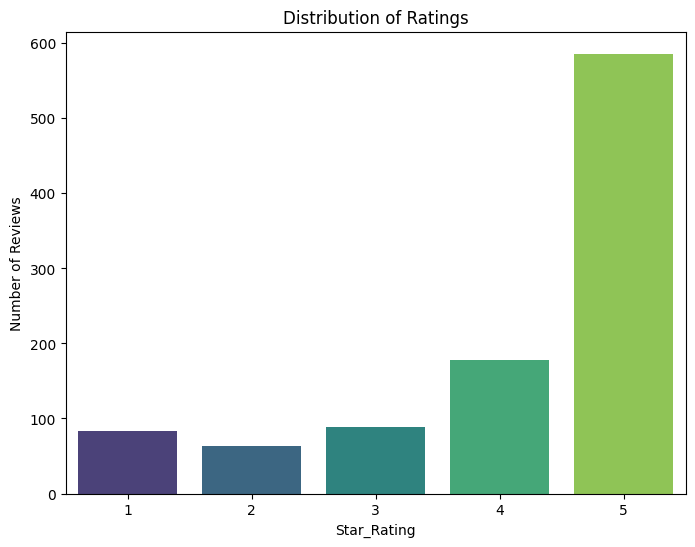

In [18]:
# Count the number of occurrences for each rating
rating_counts = df_sampled['star_rating'].value_counts().sort_index()

# Plot the distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=rating_counts.index, y=rating_counts.values, palette='viridis')
plt.title('Distribution of Ratings')
plt.xlabel('Star_Rating')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)
plt.show()


The bar chart titled "Distribution of Ratings" shows the distribution of star ratings given by users for watches. The majority of reviews have a 5-star rating, with over 600 reviews, indicating high customer satisfaction and approval. The number of reviews decreases as the ratings drop, with 4-star ratings being the second most common, followed by a relatively small number of 1-, 2-, and 3-star ratings. This suggests that most users are highly satisfied with the product, though there is a noticeable minority expressing dissatisfaction or average experiences. The skewed distribution toward higher ratings reflects overall positive feedback for the watch product.

In [19]:
def get_pos_neg_words():
    def get_words(url):
        import requests
        words = requests.get(url).content.decode('latin-1')
        word_list = words.split('\n')
        index = 0
        while index < len(word_list):
            word = word_list[index]
            if ';' in word or not word:
                word_list.pop(index)
            else:
                index+=1
        return word_list

    p_url = 'http://ptrckprry.com/course/ssd/data/positive-words.txt'
    n_url = 'http://ptrckprry.com/course/ssd/data/negative-words.txt'
    positive_words = get_words(p_url)
    negative_words = get_words(n_url)
    return positive_words,negative_words

positive_words,negative_words = get_pos_neg_words()



In [30]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
def preprocess_text(text):
    tokens = word_tokenize(text)
    return tokens

df_sampled['tokens'] = df_sampled['review_body'].apply(preprocess_text)

def sentiment_score(tokens, positive_words, negative_words):
    pos_count = sum(1 for word in tokens if word in positive_words)
    neg_count = sum(1 for word in tokens if word in negative_words)
    return pos_count, neg_count

# Apply the sentiment_score function to each review
df_sampled[['pos_count', 'neg_count']] = df_sampled['tokens'].apply(
    lambda tokens: pd.Series(sentiment_score(tokens, positive_words, negative_words))
)

# Calculate aggregate sentiment scores
total_positive = df_sampled['pos_count'].sum()
total_negative = df_sampled['neg_count'].sum()
print(f"Total Positive Words: {total_positive}")
print(f"Total Negative Words: {total_negative}")
print(f"Percent of Postive Words: {total_positive/(total_negative+total_positive)}")

Total Positive Words: 2981
Total Negative Words: 1050
Percent of Postive Words: 0.7395187298437113


<a name='Part-3-TF-IDF'></a>
# Part 3: TF-IDF

TF: Term Frequency

IDF: Inverse Document Frequency

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# define vectorizer parameters
# TfidfVectorizer will help us to create tf-idf matrix
# max_df : maximum document frequency for the given word
# min_df : minimum document frequency for the given word
# max_features: maximum number of words in the dictionary
# use_idf: if not true, we only calculate tf
# stop_words : built-in stop words
# tokenizer: how to tokenize the document
# ngram_range: (min_value, max_value), eg. (1, 3) means the result will include 1-gram, 2-gram, 3-gram
tfidf_model = TfidfVectorizer(max_df = 0.99, max_features=1000,
                                 min_df = 0.01, stop_words='english',
                                 use_idf = True, tokenizer = tokenization_and_stemming, ngram_range=(1,1))

tfidf_matrix = tfidf_model.fit_transform(data) #fit the vectorizer to synopses

print ("In total, there are " + str(tfidf_matrix.shape[0]) + \
      " reviews and " + str(tfidf_matrix.shape[1]) + " terms.")

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['afterward', 'alon', 'alreadi', 'alway', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becom', 'besid', 'cri', 'describ', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'otherwis', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev'] not in stop_words.
  war

In total, there are 1000 reviews and 395 terms.


In [ ]:
tfidf_matrix

<1000x395 sparse matrix of type '<class 'numpy.float64'>'
	with 11936 stored elements in Compressed Sparse Row format>

In [ ]:
tfidf_matrix.toarray() #todense()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.25895443,
        0.        ],
       [0.12592809, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
data[0]

'Looks very elegant and classy'

In [ ]:
tfidf_matrix.toarray()[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.72975467, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [ ]:
tfidf_matrix.todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.25895443,
         0.        ],
        [0.12592809, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [ ]:
print(type(tfidf_matrix.toarray()))

<class 'numpy.ndarray'>


In [ ]:
print(type(tfidf_matrix.todense()))

<class 'numpy.matrix'>


Save the terms identified by TF-IDF.

In [ ]:
# words
tf_selected_words = tfidf_model.get_feature_names_out()

In [ ]:
# print out words
tf_selected_words

array(['abl', 'absolut', 'accur', 'actual', 'adjust', 'advertis', 'ago',
       'alarm', 'alreadi', 'alway', 'amaz', 'amazon', 'analog', 'anoth',
       'anyon', 'appear', 'arm', 'arriv', 'ask', 'attract', 'automat',
       'away', 'awesom', 'background', 'bad', 'band', 'basic', 'batteri',
       'beat', 'beauti', 'becom', 'believ', 'best', 'better', 'bezel',
       'big', 'bigger', 'birthday', 'bit', 'black', 'blue', 'bought',
       'box', 'boyfriend', 'bracelet', 'brand', 'break', 'bright',
       'broke', 'broken', 'buckl', 'bulki', 'button', 'buy', 'ca', 'came',
       'care', 'case', 'casio', 'casual', 'chang', 'cheap', 'check',
       'choic', 'christma', 'clasp', 'classi', 'classic', 'clear',
       'clock', 'close', 'collect', 'color', 'come', 'comfort', 'comment',
       'compani', 'compar', 'complain', 'complaint', 'complet',
       'compliment', 'condit', 'consid', 'cool', 'correct', 'cost',
       'coupl', 'cours', 'cover', 'crown', 'crystal', 'custom', 'cute',
       'dai

<a name='Part-4-K-means-clustering'></a>
# Part 4: K-means clustering

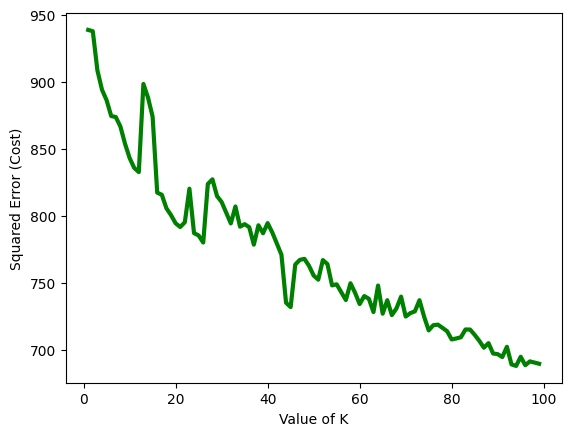

In [ ]:
from sklearn.cluster import KMeans
cost =[]
for i in range(1,100):
    KM = KMeans(n_clusters = i)
    KM.fit(tfidf_matrix)

    # calculates squared error
    # for the clustered points
    cost.append(KM.inertia_)

# plot the cost against K values
plt.plot(range(1, 100), cost, color ='g', linewidth ='3')
plt.xlabel("Value of K")
plt.ylabel("Squared Error (Cost)")
plt.show() # clear the plot

# the point of the elbow is the
# most optimal value for choosing k

Interpretation:
The graph shows a rapid decrease in the cost as K increases from 1 to around 10–20. This indicates that adding more clusters significantly reduces the squared error initially.
After a certain point (the "elbow"), the reduction in cost becomes less pronounced, and the curve flattens. This suggests that additional clusters contribute only marginally to reducing the squared error.
Optimal
K:
The elbow point is the value of
K where the cost reduction slows down. This point represents the optimal number of clusters as it balances the trade-off between reducing error and maintaining simplicity in the model.
Based on the graph, the elbow point appears to be around
=
10
K=10 to
=
20
K=20.
Take K = 15 as the optimal number of clusters.
Conclusion:
The elbow method suggests using
K near the elbow point for efficient clustering, as adding more clusters beyond this point yields diminishing returns in terms of error reduction. Further exploration with domain-specific context or validation metrics might refine the exact K.

In [ ]:
# k-means clustering

num_clusters = 15

# number of clusters
km = KMeans(n_clusters = num_clusters)
km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

## 4.1. Analyze K-means Result

In [ ]:
# create DataFrame films from all of the input files.
product = { 'review': df_sampled.review_body, 'cluster': clusters}
frame = pd.DataFrame(product, columns = ['review', 'cluster'])

In [ ]:
frame.head(10)

,review,cluster
0,Looks very elegant and classy,14
1,The watch face on this watch is rather large a...,14
2,I purchased this watch for my wife's birthday ...,14
3,This review is based on initial impressions on...,14
4,When my 10 year old Timex finally broke the ba...,14
5,The watch is fine. There are a lot of bells an...,14
6,Good Quality. Fast Shipment,7
7,I love it !! I think I am going to get one more!,6
8,Nice,14
9,Love this watch!! It's the perfect rose gold c...,14


In [ ]:
print ("Number of reviews included in each cluster:")
frame['cluster'].value_counts().to_frame()

Number of reviews included in each cluster:


,count
cluster,
14,879
8,34
10,33
13,27
2,8
1,7
7,2
6,2
3,2


1. Dominant Cluster (Cluster 14):
Cluster 14 contains the majority of reviews (879 out of the total), suggesting that most reviews share common characteristics or themes. This cluster likely represents a general sentiment or topic prevalent in the dataset.
2. Smaller Clusters:
Clusters 8, 10, and 13 have 34, 33, and 27 reviews, respectively. These clusters represent distinct subgroups of reviews, which might be focused on specific aspects, such as unique features, complaints, or praise.
3. Outlier Clusters:
Several clusters (e.g., 0, 1, 2, 3, 4, 5, 6, 7, 9, 11, and 12) contain fewer than 10 reviews, with some having just 1 or 2 reviews. These could represent outliers or very niche topics discussed by a small number of users.
4. Imbalanced Distribution:
The distribution is heavily imbalanced, with one dominant cluster and several smaller ones. This suggests that the reviews dataset is not evenly distributed across themes. A small number of themes likely dominate the discussions, while others are only mentioned briefly.


In [ ]:
km.cluster_centers_

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.04929424,
        0.        ],
       [0.        , 0.06233316, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.01418017, ..., 0.        , 0.        ,
        0.        ],
       [0.00512784, 0.00612275, 0.0057605 , ..., 0.00233144, 0.01758025,
        0.00343093]])

In [ ]:
km.cluster_centers_.shape

(15, 395)

In [ ]:
print ("<Document clustering result by K-means>")

#km.cluster_centers_ denotes the importances of each items in centroid.
#We need to sort it in decreasing-order and get the top k items.
order_centroids = km.cluster_centers_.argsort()[:, ::-1]

Cluster_keywords_summary = {}
for i in range(num_clusters):
    print ("Cluster " + str(i) + " words:", end='')
    Cluster_keywords_summary[i] = []
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        Cluster_keywords_summary[i].append(tf_selected_words[ind])
        print (tf_selected_words[ind] + ",", end='')
    print ()

    cluster_reviews = frame[frame.cluster==i].review.tolist()
    print ("Cluster " + str(i) + " reviews (" + str(len(cluster_reviews)) + " reviews): ")
    #print (", ".join(cluster_reviews))
    print ()

<Document clustering result by K-means>
Cluster 0 words:screw,miss,boyfriend,pin,present,ago,
Cluster 0 reviews (1 reviews): 

Cluster 1 words:origin,band,replac,onlin,happi,qualiti,
Cluster 1 reviews (7 reviews): 

Cluster 2 words:husband,love,good,gift,realli,buy,
Cluster 2 reviews (8 reviews): 

Cluster 3 words:easi,rubber,metal,use,band,wrist,
Cluster 3 reviews (2 reviews): 

Cluster 4 words:wrist,issu,wear,come,type,arm,
Cluster 4 reviews (1 reviews): 

Cluster 5 words:sinc,look,went,suggest,glad,onlin,
Cluster 5 reviews (1 reviews): 

Cluster 6 words:think,love,christma,big,face,yes,
Cluster 6 reviews (2 reviews): 

Cluster 7 words:fast,good,qualiti,exact,excel,expect,
Cluster 7 reviews (2 reviews): 

Cluster 8 words:love,daughter,present,fit,perfect,day,
Cluster 8 reviews (34 reviews): 

Cluster 9 words:product,wonder,alreadi,dive,timepiec,ago,
Cluster 9 reviews (1 reviews): 

Cluster 10 words:good,qualiti,nice,look,valu,servic,
Cluster 10 reviews (33 reviews): 

Cluster 11 word

The K-means clustering results reveal key themes in watch reviews, with Cluster 14 dominating (879 reviews) and reflecting general positive sentiments about design, functionality, and overall satisfaction. Substantial clusters, such as Cluster 8 (focused on gifts for daughters), Cluster 10 (highlighting quality and value), and Cluster 13 (emphasizing high quality and recommendations), reinforce the strong approval from customers. Smaller clusters capture niche themes, like watches as gifts for husbands (Cluster 2), discussions on band materials and usability (Cluster 3), and fit issues (Cluster 4). Outlier clusters (e.g., Clusters 0, 5, and 9) address specific topics, such as mechanical issues, online purchasing, or unique product features. Overall, positive feedback dominates, but insights from smaller clusters can guide improvements in fit, usability, and targeted marketing for specific customer needs.

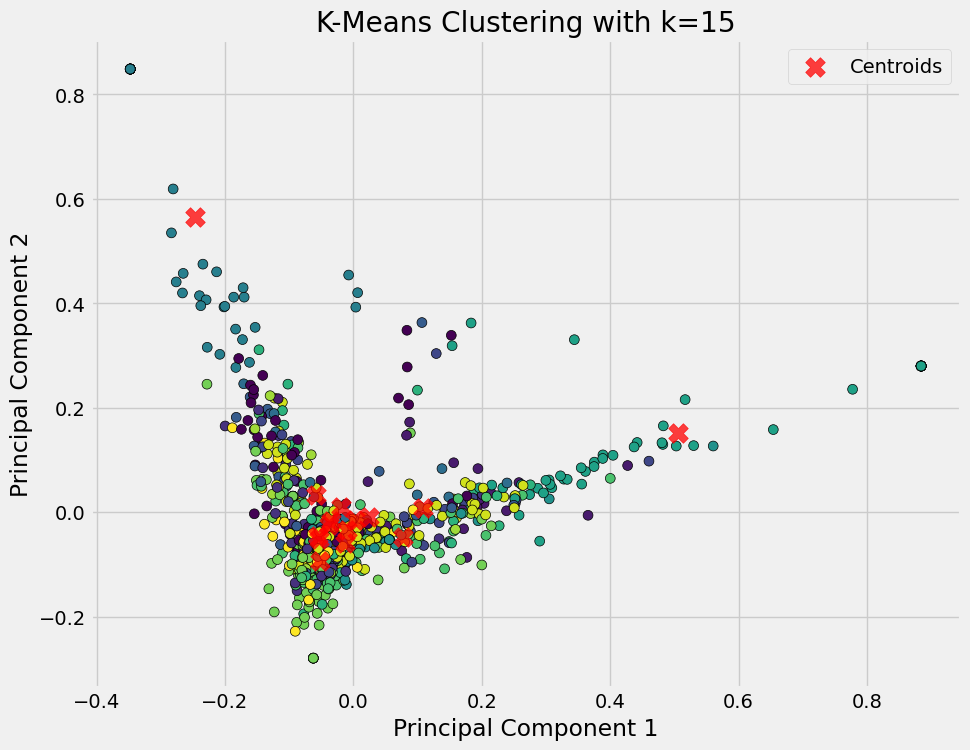

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42)
tfidf_reduced = pca.fit_transform(tfidf_matrix.toarray())

k = 15
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(tfidf_matrix)
labels = kmeans.predict(tfidf_matrix)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(tfidf_reduced[:, 0], tfidf_reduced[:, 1], c=labels, cmap='viridis', edgecolor='k', s=50)
plt.title(f'K-Means Clustering with k={k}')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Plot the centroids
centroids = kmeans.cluster_centers_
centroids_reduced = pca.transform(centroids)
plt.scatter(centroids_reduced[:, 0], centroids_reduced[:, 1], c='red', s=200, alpha=0.75, marker='X', label='Centroids')

plt.legend()
plt.show()


<a name='Part-5-Topic-Modeling-Latent-Dirichlet-Allocat'></a>
# Part 5: Topic Modeling - Latent Dirichlet Allocation

In [ ]:
# Use LDA for clustering
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components = 15)

In [ ]:
# document topic matrix for tfidf_matrix_lda
# probability of each row of review in 15 topic
lda_output = lda.fit_transform(tfidf_matrix)
print(lda_output.shape)
print(lda_output)

(1000, 15)
[[0.02522213 0.02522215 0.02522213 ... 0.02522214 0.02522213 0.64688982]
 [0.03733646 0.01102274 0.01102254 ... 0.01102256 0.01102253 0.01102255]
 [0.01694555 0.01694565 0.01694561 ... 0.01694567 0.60390765 0.0169456 ]
 ...
 [0.16819328 0.05357905 0.09861383 ... 0.01271819 0.01271824 0.01271829]
 [0.01193145 0.01193259 0.01193148 ... 0.01193146 0.01193143 0.01193189]
 [0.02128315 0.02128307 0.02128299 ... 0.02128297 0.02128309 0.02128321]]


In [ ]:
# column names
topic_names = ["Topic" + str(i) for i in range(lda.n_components)]

# index names
doc_names = ["Review" + str(i) for i in range(len(data))]

df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topic_names, index=doc_names)

# get dominant topic for each document
topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['final_topic'] = topic

df_document_topic.head(10)

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,final_topic
Review0,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.65,14
Review1,0.04,0.01,0.01,0.01,0.01,0.01,0.04,0.18,0.62,0.01,0.01,0.01,0.01,0.01,0.01,8
Review2,0.02,0.02,0.02,0.02,0.02,0.18,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.60,0.02,13
Review3,0.01,0.30,0.01,0.01,0.01,0.38,0.01,0.01,0.21,0.01,0.01,0.01,0.01,0.01,0.02,5
Review4,0.47,0.28,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.11,0
Review5,0.02,0.02,0.02,0.02,0.18,0.42,0.02,0.02,0.02,0.02,0.02,0.02,0.22,0.02,0.02,5
Review6,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.36,0.32,0.02,12
Review7,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.61,0.03,13
Review8,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.53,0.03,0.03,12
Review9,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.46,0.01,0.01,0.16,0.01,0.01,0.21,8


In [ ]:
df_document_topic['final_topic'].value_counts().to_frame()

,count
final_topic,
8,206
1,113
13,87
7,86
12,79
0,74
14,69
6,55
3,41


In [ ]:
# topics and words matrix
# probability of 395 feature in 15 topic
topic_word = lda.components_
print(topic_word.shape)
print(topic_word)

(15, 395)
[[0.0666669  0.06666677 1.02261495 ... 0.06666677 2.67794584 0.06666669]
 [0.06666739 0.06666857 0.06666723 ... 1.20705927 2.22685721 3.0824514 ]
 [0.06666667 0.06666667 0.06666668 ... 0.06666673 0.41232887 0.06666667]
 ...
 [0.06666679 0.06666669 0.06666677 ... 0.06666667 0.06666667 0.06666667]
 [0.06666668 5.17231282 0.06666667 ... 0.06666667 2.46955522 0.06666667]
 [0.06666667 0.48430677 0.06666673 ... 0.06666669 0.0666668  0.06666671]]


In [ ]:
# topic word matrix
print(lda.components_)
# topic-word matrix
df_topic_words = pd.DataFrame(lda.components_)

# column and index
df_topic_words.columns = tfidf_model.get_feature_names_out()
df_topic_words.index = topic_names

df_topic_words

[[0.0666669  0.06666677 1.02261495 ... 0.06666677 2.67794584 0.06666669]
 [0.06666739 0.06666857 0.06666723 ... 1.20705927 2.22685721 3.0824514 ]
 [0.06666667 0.06666667 0.06666668 ... 0.06666673 0.41232887 0.06666667]
 ...
 [0.06666679 0.06666669 0.06666677 ... 0.06666667 0.06666667 0.06666667]
 [0.06666668 5.17231282 0.06666667 ... 0.06666667 2.46955522 0.06666667]
 [0.06666667 0.48430677 0.06666673 ... 0.06666669 0.0666668  0.06666671]]


,abl,absolut,accur,actual,adjust,advertis,ago,alarm,alreadi,alway,...,wonder,wore,work,worn,worri,worth,wrist,wrong,year,yes
Topic0,0.066667,0.066667,1.022615,0.066699,0.066667,2.328051,0.066667,0.066667,0.986250,0.364457,...,1.823137,0.066667,4.798291,0.066671,0.066667,0.066667,0.066667,0.066667,2.677946,0.066667
Topic1,0.066667,0.066669,0.066667,0.066682,0.066667,0.066667,3.318594,3.030110,0.445392,0.134730,...,0.066667,0.066667,4.850103,0.266541,1.089310,0.291119,1.402540,1.207059,2.226857,3.082451
Topic2,0.066667,0.066667,0.066667,0.179673,0.373611,0.066667,0.066667,0.066667,0.066667,0.564829,...,0.066667,0.066667,0.070020,0.066667,0.066667,0.066667,0.066667,0.066667,0.412329,0.066667
Topic3,0.424658,0.417273,0.066667,0.066673,0.066667,0.066667,0.066667,2.403803,0.066667,0.700182,...,0.066667,0.066667,1.088586,0.066667,0.066667,0.066667,1.131542,0.066667,0.066667,0.066667
Topic4,0.066667,0.066667,0.066667,0.066667,1.858110,0.440951,0.066667,0.066667,0.066667,0.809673,...,0.066667,1.465412,0.435996,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667
Topic5,0.066667,0.066668,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.776155,...,0.066667,0.066667,1.120948,0.306251,0.066667,3.170346,0.814121,0.066667,0.066667,0.066667
Topic6,0.066667,0.066667,2.004423,1.686380,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,...,0.066667,0.066667,1.799045,0.066667,0.066667,0.066667,0.066667,0.557160,0.378408,0.066667
Topic7,4.054491,0.066670,2.582877,1.232299,0.066667,0.066667,0.573060,0.066667,2.231792,0.066667,...,1.743629,0.066667,3.802946,0.066667,1.914227,2.928926,3.849935,0.066667,1.008539,0.066667
Topic8,0.228220,0.066668,0.066667,3.614614,3.735175,0.066669,0.066667,0.066667,0.066667,0.066667,...,0.066667,1.517513,3.178034,3.206158,0.066667,1.527372,5.354038,0.588609,4.672761,0.066667
Topic9,0.066667,0.066667,0.066667,0.815595,0.534054,0.066667,0.066667,0.066667,0.066667,0.271620,...,0.538762,0.066667,0.390713,0.066667,0.066667,0.940492,0.280518,0.066667,0.429234,0.066667


In [ ]:
# print top n keywords for each topic
def print_topic_words(tfidf_model, lda_model, n_words):
    words = np.array(tfidf_model.get_feature_names_out())
    topic_words = []
    # for each topic, we have words weight
    for topic_words_weights in lda_model.components_:
        top_words = topic_words_weights.argsort()[::-1][:n_words] #argsort in ascending order and [::-1] reverse the order, and [:n_words] by the first n_words.
        topic_words.append(words.take(top_words))
    return topic_words

topic_keywords = print_topic_words(tfidf_model=tfidf_model, lda_model=lda, n_words=15)

df_topic_words = pd.DataFrame(topic_keywords)
df_topic_words.columns = ['Word '+str(i) for i in range(df_topic_words.shape[1])]
df_topic_words.index = ['Topic '+str(i) for i in range(df_topic_words.shape[0])]
df_topic_words

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,product,buy,excel,great,need,work,batteri,sent,servic,repair,warranti,chang,condit,everyth,exact
Topic 1,time,expect,weight,set,like,look,disappoint,week,differ,day,thought,gave,work,bigger,thing
Topic 2,seller,stylish,great,item,easi,exact,recommend,return,sure,price,break,state,like,expect,order
Topic 3,look,day,real,cool,great,save,cheap,love,alarm,time,timex,line,realli,perfect,blue
Topic 4,like,come,new,im,adjust,wore,instruct,receiv,band,say,classi,everyday,alway,quick,miss
Topic 5,button,style,lot,appear,set,design,worth,like,plastic,money,littl,press,make,guess,excel
Topic 6,excel,read,easi,light,dark,featur,date,origin,hard,time,ca,illumin,dial,figur,love
Topic 7,son,purchas,watch,look,abl,time,like,wrist,quit,work,month,casio,pin,display,set
Topic 8,band,look,nice,watch,great,leather,box,compliment,good,time,strap,bought,face,fit,like
Topic 9,wife,eleg,invicta,anoth,look,love,gift,bought,solid,watch,great,men,qualiti,cute,excel


The LDA analysis reveals key themes in watch reviews, highlighting positive sentiments around design, gifting, affordability, and usability, as seen in topics focusing on simplicity, elegance, and features like illumination and durability. Gifting occasions such as birthdays and Christmas are prominently discussed, reflecting the watches' appeal as thoughtful presents. Practical aspects like repair services, adjustability, and fit also appear, indicating areas for improvement, alongside occasional dissatisfaction with unmet expectations. Topics related to value for money, band materials, and usability in low-light conditions emphasize functional and aesthetic preferences. These insights suggest opportunities to enhance product features, address fit and service concerns, and market watches as versatile, gift-worthy items.